In [1]:
# %load ./scripts/do_RT_thermal.py
from pylab import *
import radmc3dPy as rpy
import numpy as np
import os
from scipy import interpolate
import sys
#sys.path.append('../')
from models import *

In [9]:
from scipy import stats

In [62]:
from scipy.ndimage.filters import uniform_filter1d, gaussian_filter1d

In [181]:
#gma_params = {'incl': 53.21, 'pa':57.17, 'dpc':159, 'dpc_err': 4}
gma_params = {'incl': 53.21, 'pa':0, 'dpc':159, 'dpc_err': 4}

def make_contimage(mu,sizeau=400,npix=400,params={}):
    if params == {}:
        incl = 0
        pa = 0
    else:
        incl = params['incl']
        pa = params['pa']
    command = 'radmc3d image npix {} sizeau {} incl {} lambda {} posang {} noscat setthreads 64'.format(npix,sizeau,incl,mu,pa)
    os.system(command)
    
def make_contlist(params):
    npix = 600
    sizeau = 600
    if params == {}:
        incl = 0
        pa = 0
    else:
        incl = params['incl']
        pa = params['pa']
    command = 'radmc3d image npix {} sizeau {} incl {} posang {} loadlambda noscat'.format(npix,sizeau,incl,pa)
    os.system(command)
    
def snu_units(image,dpc,fwhm =None,ifreq=0):
    dum_image = image
    data_im = np.squeeze(dum_image.image[:, ::-1, ifreq].T)
    data = data_im.copy()
    pixel_area = (dum_image.sizepix_x * dum_image.sizepix_y)/(dpc * pc)**2 * (180./np.pi*3600.)**2
    #beam_area = image.fwhm[0] * image.fwhm[1] * np.pi / 4. / np.log(2.0)
    data *= (dum_image.sizepix_x * dum_image.sizepix_y / (dpc * pc)**2. * 1e23)
    # Convert data to mJy/beam
    if fwhm is not None:
        beam_area = fwhm[0] * fwhm[1] * np.pi / 4. / np.log(2.0)
        data *= beam_area/ pixel_area
    data *= 1e3
    x = dum_image.x / AU #/ dpc
    y = dum_image.y / AU #/ dpc
    return x,y,data

def plot_ic_half(run,cmap,ax,vmin,vmax):
    os.chdir(run.m.outdir)
    im = rpy.image.readImage()
    fwhm_au= (12,12)
    fwhm = np.array(fwhm_au)/159.
    imc = im.imConv(dpc=159.,fwhm=fwhm,pa=0.0)
    x,y,data= snu_units(imc,159,fwhm,ifreq=0)
    half = int(len(x)/2)
    toplot = data
    imm = ax.pcolormesh(x[half:],y,toplot[:,:half][::-1,::-1],cmap=cmap,vmin=vmin,vmax=vmax,rasterized=True,shading='auto')
    return imm


class obs:
    def __init__(self,outdir,params):
        self.par = params
        self.dir = outdir
        self.I = {}
        self.Ic = {}
        if 'dpc' in params.keys():
            self.dpc = params['dpc']
        
    def make_contimage(self,mu,sizeau=400,npix=400,incl=0,pa=0):
        os.chdir(self.dir)
        write_main(run.m, scat=1,nphot=100000,mrw=1,maxtau=5)
        if 'incl' in self.par.keys() and incl is None:
            incl = self.par['incl']
        if 'pa' in self.par.keys() and pa is None:
            pa = self.par['pa']
        command = 'radmc3d image npix {} sizeau {} incl {} lambda {} posang {} nphot_scat 1000000 setthreads 64'.format(npix,sizeau,incl,mu,pa)
        os.system(command)   
    
    def read(self,key='1.3'):
        os.chdir(self.dir)
        im=rpy.image.readImage(binary=False)
        self.freq = im.freq
        self.nfreq = im.nfreq
        self.nx = im.nx
        self.ny = im.ny
        self.y = im.y/AU
        self.x = im.x/AU
        self.I[key] = im
        
    def project_coords(self,x,y,z=None,incl=None,pa=None,inv=True):
        if 'incl' in self.par.keys() and incl is None:
            incl = self.par['incl']
        if 'pa' in self.par.keys() and pa is None:
            pa = self.par['pa']
        if inv == True:
            y /= np.cos(np.radians(incl))
        else:
            y *= np.cos(np.radians(incl))
        
        return x,y
        
    def plot_im_basic(self,I,fwhm=None,ifreq=0,**pkw):
        x,y,data = snu_units(I,self.dpc,fwhm=fwhm,ifreq=ifreq)
        im = pcolormesh(x,y,data,**pkw)
        return im 
    
    def plot_im_deproject(self,I,fwhm=None,incl=None,pa=None,ifreq=0,**pkw):
        x,y,data = snu_units(I,self.dpc,fwhm=fwhm,ifreq=ifreq)
        X,Y = np.meshgrid(x,y)
        Xr,Yr = self.project_coords(X,Y,incl=incl,pa=pa,inv=True)
        im = pcolormesh(Xr,Yr,data,**pkw)
    
    def convolve(self,key,I_in,beam_au=[10,10],fwhm=None,pa=0):
        if fwhm is None:
            fwhm = np.array(beam_au)/self.dpc
            self.fwhm = fwhm
        else:
            self.fwhm = fwhm
        self.Ic[key] = I_in.imConv(fwhm=fwhm,pa=pa, dpc=self.dpc)
        
        
    def bin_radial(self,I,fwhm=None,nbin=100,incl=None,pa=None,rmin=10,rmax=300,ifreq=0,stat='mean'):
        x,y,Idata = snu_units(I,self.dpc,fwhm=fwhm,ifreq=ifreq)
        X,Y = np.meshgrid(x,y)
        Xr,Yr = self.project_coords(X,Y,incl=incl,pa=pa,inv=True)
        rdata = np.sqrt(Xr**2 + Yr**2)
        rbin_e = np.linspace(rmin,rmax,nbin)
        rbin = 0.5*(rbin_e[1:] + rbin_e[:-1])
        I_r = stats.binned_statistic(rdata.flatten(),Idata.flatten(),bins=rbin_e,statistic=stat)[0]
        
        return rbin, I_r
    
        
    def plot_im_radial(self,I,fwhm=None,nbin=100,incl=None,pa=None,rmin=10,rmax=400,ifreq=0,stat='mean',relmax=False,**pkw):
        rbin, I_r = self.bin_radial(I,fwhm=fwhm,nbin=nbin,incl=incl,pa=pa,rmin=rmin,rmax=rmax,stat=stat,ifreq=freq)
        if relmax==True:
            Imax = np.nanmax(I_r)
            plot(rbin,I_r/Imax,**pkw)
        else:
            plot(rbin,I_r, **pkw)
        


nu_list = np.array([100,150,226,257,283])*1e9
mu_list = 1e4*(c/(nu_list))
print(mu_list)
fwhm_list = np.array([[295,210],[57,35],[130,94],[117,83],[270,162]])*1e-3
pa_list = 57.17 - np.array([5.7,-13.8,9.1,-1.5,0.1]) 
noise_list =np.array([12.4,11.3,16.7,21.9,57.6])*1e-3

obs_params = {'nu': nu_list, 'wav':mu_list, 'fwhm':fwhm_list, 'pa':pa_list,'noise':noise_list}



def compare_models(oms,colors,ifr=0,Imax=True,):
    for om,cc in zip(oms,colors):
        mu_val = obs_params['wav'][ifr]
        nu_val = obs_params['nu'][ifr]
        R = gma_data['R']
        I_val = 'I'+str(int(nu_val/1e9))
        
        om.convolve(key=I_val,I_in=om.I['all'], fwhm=fwhm_list[ifr],pa=pa_list[ifr])
        #om.convolve(key=I_val,I_in=om.I['all'], beam_au=[32,32],pa=pa_list[ifr])
        r, Imean = om.bin_radial(om.Ic[I_val],nbin=600,fwhm=om.fwhm,rmin=10,stat='mean',ifreq=ifr,rmax=300)
        r, Imx = om.bin_radial(om.Ic[I_val],nbin=600,fwhm=om.fwhm,rmin=10,stat='max',ifreq=ifr,rmax=300)
        r, Imn = om.bin_radial(om.Ic[I_val],nbin=600,fwhm=om.fwhm,rmin=10,stat='min',ifreq=ifr,rmax=300)
        
        if Imax == True:
            I_max = np.amax(Imean)
            plot(r,Imean/I_max,color=cc)
            fill_between(r,Imn/I_max, Imx/I_max, alpha=0.45,color=cc)
            
        else:
            plot(r,Imean,color=cc)
            fill_between(r,Imn, Imx, alpha=0.45,color=cc)
        yscale('log')
    Iobs = gma_data[I_val]*1000
    Iobs_err = gma_data['d'+I_val]*1000*3
    if Imax == True:
        Iobs_max= np.amax(Iobs)
        plot(R, Iobs/Iobs_max,color='black')
        fill_between(R,(Iobs-Iobs_err)/Iobs_max, (Iobs+Iobs_err)/Iobs_max,alpha=0.5,color='black')
    else:
        plot(R, Iobs,color='black')
        fill_between(R,(Iobs-Iobs_err), (Iobs+Iobs_err),alpha=0.5,color='black')
    

def blur_features(om,color,ifr=0):
    mu_val = obs_params['wav'][ifr]
    nu_val = obs_params['nu'][ifr]
    I_val = 'I'+str(int(nu_val/1e9))
    res_vals = [1,5,10,15,30]
    for k,cc in zip(res_vals,np.linspace(0.25,1,len(res_vals))[::-1]):
        om.convolve(key=I_val+str(k),I_in=om.I['all'], beam_au=[k,k],pa=57.17)
        r, Imean = om.bin_radial(om.Ic[I_val+str(k)],nbin=600,fwhm=om.fwhm,rmin=1,stat='mean',ifreq=ifr,rmax=350)
        r, Imx = om.bin_radial(om.Ic[I_val+str(k)],nbin=600,fwhm=om.fwhm,rmin=1,stat='max',ifreq=ifr,rmax=350)
        r, Imn = om.bin_radial(om.Ic[I_val+str(k)],nbin=600,fwhm=om.fwhm,rmin=1,stat='min',ifreq=ifr,rmax=350)
        plot(r,Imean,alpha=cc,color=color)
        fill_between(r,Imn, Imx, alpha=0.1,color=color)
        yscale('log')

dn1 = '/home/akuznetsova/wedgeford/out/gmaur/gm2a/'  
dn2 = '/home/akuznetsova/wedgeford/out/gmaur/gm2b/'  
dn3 = '/home/akuznetsova/wedgeford/out/gmaur/gm2c/'  
dn4 = '/home/akuznetsova/wedgeford/out/gmaur/gm02c/'  
o1 = obs(dn1,gma_params)
o1.read(key='all')
o2 = obs(dn2,gma_params)
o2.read(key='all')
o3 = obs(dn3,gma_params)
o3.read(key='all')
#o4 = obs(dn4,gma_params)
#o4.read(key='all')


[2997.92458    1998.61638667 1326.51530088 1166.50761868 1059.33730742]
Reading image.out
Reading image.out
Reading image.out


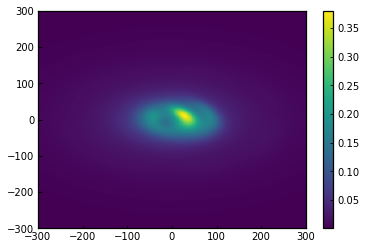

In [192]:
o1.convolve(key='2.1',I_in=om.I['all'],fwhm=[0.25,0.15],pa=57.17)
o1.plot_im_basic(o1.Ic['2.1'],fwhm=o1.fwhm)
colorbar()

[0.057, 0.034]
[0.057, 0.034]
[0.057, 0.034]


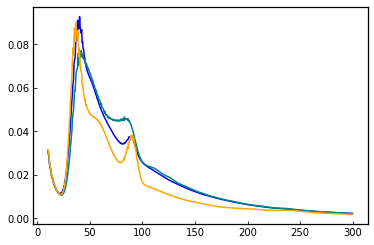

In [195]:
for om, cc in zip([o1,o2,o3],['blue','teal','orange']):
    I_val = '2.1'
    om.convolve(key=I_val,I_in=om.I['all'],fwhm=[0.057,0.034],pa=57.17)
    print(om.fwhm)
    r,Im = om.bin_radial(om.Ic[I_val],fwhm=om.fwhm,nbin=600,rmin=10,rmax=300,ifreq=1,stat='mean')
    plot(r,Im,color=cc)
    

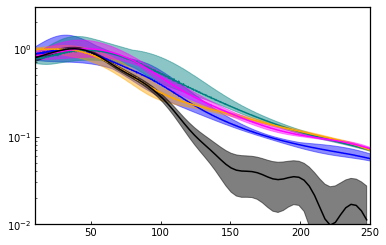

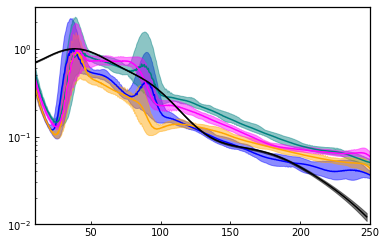

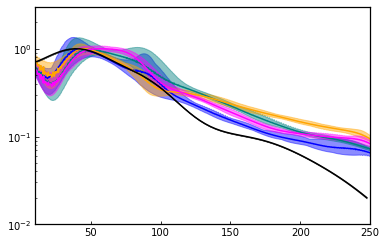

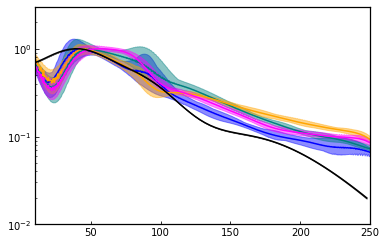

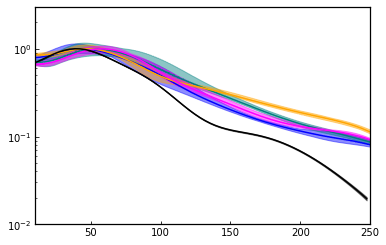

In [164]:
for j in range(o1.nfreq):
    #blur_features(o1,ifr=j)
    compare_models([o1,o2,o3,o4],colors=['blue','teal','orange','magenta'],ifr=j,Imax=True)
    ylim(1e-2,3)
    xlim(10,250)
    show()
    

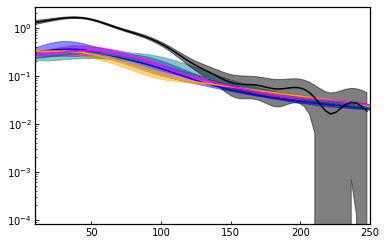

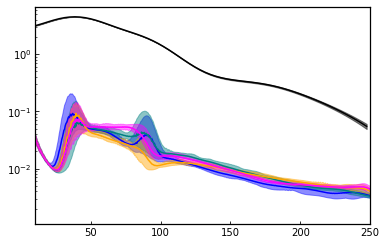

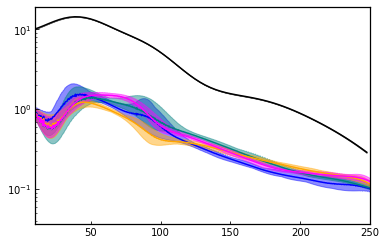

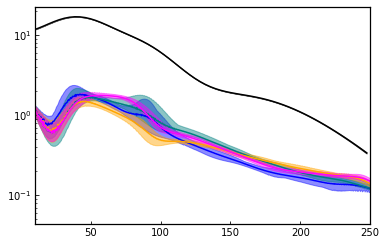

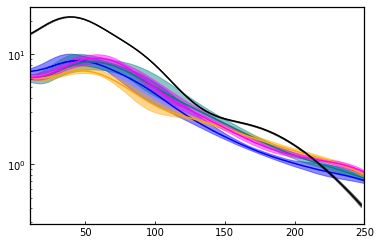

In [166]:
for j in range(o1.nfreq):
    #blur_features(o1,ifr=j)
    compare_models([o1,o2,o3,o4],colors=['blue','teal','orange','magenta'],ifr=j,Imax=False)
    xlim(10,250)
    show()
    

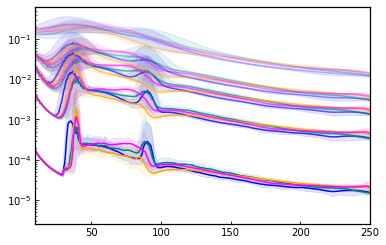

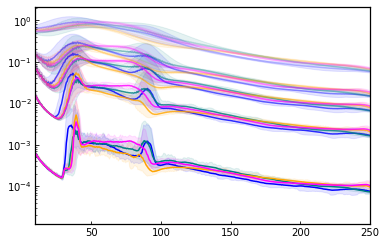

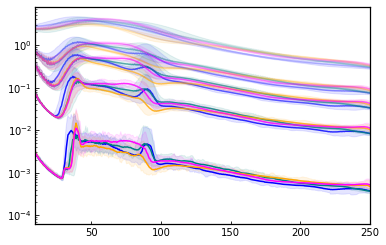

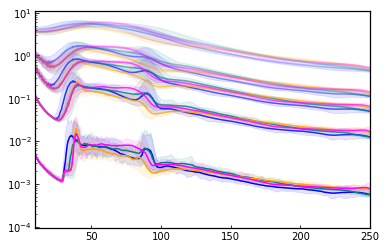

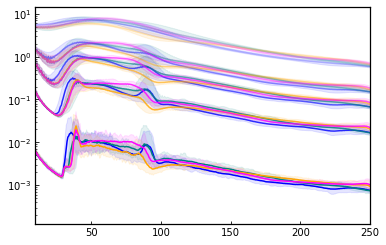

In [140]:
for j in range(o1.nfreq):
    blur_features(o1,ifr=j,color='blue')
    blur_features(o2,ifr=j,color='teal')
    blur_features(o3,ifr=j,color='orange')
    blur_features(o4,ifr=j,color='magenta')
    xlim(10,250)
    show()

['R' 'I100' 'dI100' 'I150' 'dI150' 'I226' 'dI226' 'I257' 'dI257' 'I283'
 'dI283'] ['(arcsec)' '(Jy/beam)' '(Jy/beam)' '(Jy/beam)' '(Jy/beam)' '(Jy/beam)'
 '(Jy/beam)' '(Jy/beam)' '(Jy/beam)' '(Jy/beam)' '(Jy/beam)']


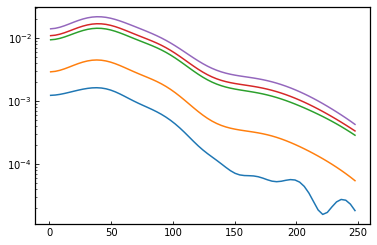

In [142]:
filename = '/home/akuznetsova/wedgeford/out/gmaur/GM_Aur_cont.txt'
headers = np.loadtxt(filename,max_rows=1,unpack=True,dtype='str')
columns = headers[::2]
units = headers[1::2]
data = np.loadtxt(filename,skiprows=1,unpack=True)
gma_data = dict(zip(columns,data))

print(columns,units)

plot(gma_data['R'],gma_data['I100'])
plot(gma_data['R'],gma_data['I150'])
plot(gma_data['R'],gma_data['I226'])
plot(gma_data['R'],gma_data['I257'])
plot(gma_data['R'],gma_data['I283'])
yscale('log')